# Image Classification using Convolutional Neural Networks


## CIFAR10 Dataset
For this Project, we'll use the CIFAR10 dataset, which consists of 60000 32x32 px colour images in 10 classes. Here are some sample images from the dataset:
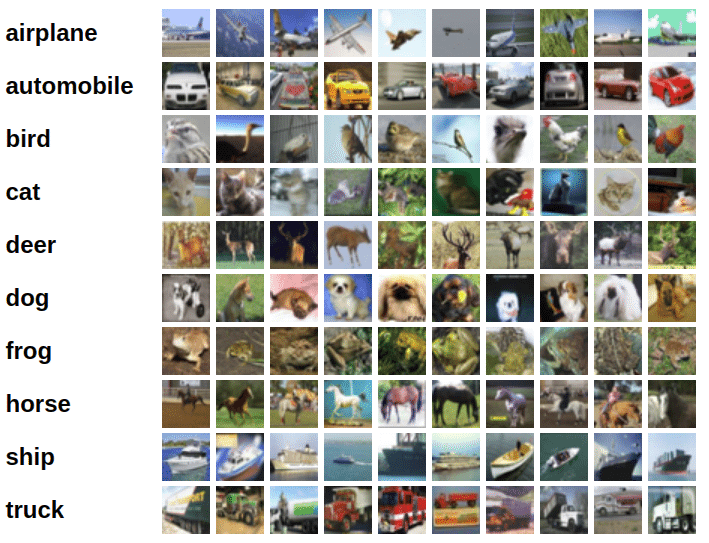

## Import libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import  DataLoader
import torch.optim as optim

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loding Dataset

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
batchSize = 64

Since we don't have dataset , we have to download it.

In [ ]:
train_dataset = torchvision.datasets.CIFAR10("./Cifar10",train=True,transform=transform,target_transform=None,download=True)
test_dataset= torchvision.datasets.CIFAR10("./Cifar10",train=False,transform=transform,target_transform=None,download=True)

We can not pass the whole dataset into our model to train it, because our memory size is fixed and there is a high chance that our training data exceed the memory capacity of CPU or GPU, so we split the dataset into batches and instead of training the model on whole in a single phase. The batch size can be decided according to memory capacity, generally, it takes in power of 2. For example, the batch size can be 16, 32, 64, 128, 256, etc.


In [ ]:
train_loader = DataLoader(dataset=train_dataset,batch_size=batchSize,shuffle=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=batchSize,shuffle=True)

dataset class:

In [ ]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### Show Some Sample form dataset

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

In [ ]:
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batchSize)))

## Make Model

### Convolution, Padding, Stride, Maxpooling;
Now understand the concept of convolution, padding, and max-pooling that help our neural network to learn the features from the images.

> According to Wikipedia Convolution is a mathematical operation which can be performed on two functions to generate third function that shows how shape of one modified by other.

Here, the first function is the image tensor, and the second function is the matrix or tensor of the image with the same number of channels as our image called the kernel. Kernels are applied to the images to learn features from the images. Basically, the kernel performs dot product for each segment of the image and then sums the result and gives the output tensor. It can be understood easily by the following image:

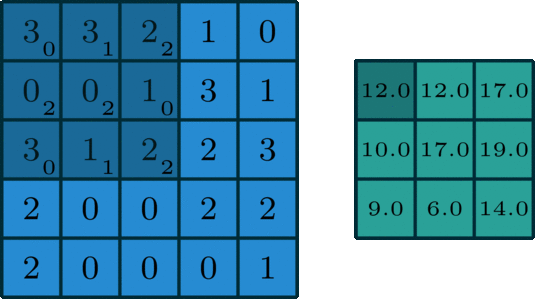

### Padding:

When we apply a kernel to the image tensor in convolution, it reduces the size of the output tensor for the image. It causes two problems, first, it shrinks the output and the second is that pixel on the corner of the image losses its importance.

To resolve these issues we increase the shape of the image by adding some extra pixels to the border of the image tensor. It helps to increase the size of the image, and the pixel value of boundaries of images shifted inside the tensor. The features learned from them conveyed to further layers in deep neural networks.

In the image below zero-padding added to the 2-D tensor.
![Padding](https://xrds.acm.org/blog/wp-content/uploads/2016/06/Figure_3.png)

### Stride:

Stride controls the activity of the kernel, how the kernel moves across the image. For example, if the stride is set to (1,1), the kernel moves across the width and height by 1 pixel at a time. The first kernel moves across the width by 1 pixel, after completing the operation across the width it moves 1 pixel in height and again repeats the process. If the stride set (2,2) then the kernel moves across the image tensor by two pixels.

### Pooling:

The pooling layer helps to summarise the result obtained by the convolution layer (also called feature map) in a lower dimension. There are various types of pooling like Max-Pooling, Average-Pooling, etc. Max-pooling often used, the image below described it more precisely:
![Pooling](https://media.geeksforgeeks.org/wp-content/uploads/20190721025744/Screenshot-2019-07-21-at-2.57.13-AM.png)

After knowing all these concepts now we define our CNN model, which includes all these concepts to learn the features from the images and train the model.

In this model, there are 3 CNN blocks, and each block consists of 2 convolution layers and 1 max-pooling layer. Relu activation function is used to remove negative values from the feature map because there can not be negative values for any pixel value. Stride(1,1) used and padding is also 1.

After applying convolution and extract features from the image, a flatten layer is used to flat the tensor which has 3 dimensions. The flatten layer converts the tensor to one-dimensional. Then 3 linear added to reduce the size of the tensor and learn the features.

Architecture of our CNN Model:

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, x):
        return self.network(x)


net = Net()
net.to(device)

### Define Optimizer and LossFunction

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

### Train Model

In [ ]:
num_epochs = 15
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        # train = Variable(images.view(100, 1, 28, 28))
        # labels = Variable(labels)
        
        # Forward pass 
        outputs = net(images)
        loss = criterion(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                # test = Variable(images.view(100, 1, 28, 28))
            
                outputs = net(images)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data.detach().cpu())
            iteration_list.append(count)
            accuracy_list.append(accuracy.detach().cpu())
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

### Saving Model

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### Show Perdiction Result

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(64)))